# chapter figures

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cartopy
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from utility_functions import scale_bar, dist_to_coords, savefig, letterboxes, turner_cmap, labels
from detect_staircases import classify_staircase
style.use('presentation.mplstyle')

In [2]:
from data_prep import glider_df, glider_av_df
ds_vdb = xr.open_dataset('data/vanderboog_argo_data.nc')
df_dissapation = pd.read_csv('data/microstructure_dissapation.csv')

In [3]:
good_dive_mask = np.empty((len(glider_df)), dtype=bool)
good_dive_mask[:] = True
bad_dives = (22, 22,5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    good_dive_mask[(glider_df.dive_num==dive) & (glider_df.glider=='sg637')] = False
glider_df = glider_df[good_dive_mask]

In [4]:
df_glider_1m = pd.read_csv('data/glider_1m_staircase.csv', low_memory=False)
mixes = pd.read_csv('data/glider_1m_mixed_layers.csv')
grads = pd.read_csv('data/glider_1m_grad_layers.csv')

In [5]:
ctd_df = pd.read_csv('data/meteor_ctd_proc.csv')

In [6]:
df_micro_1m = pd.read_csv('data/micro_1m_staircase.csv')

/home/callum/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
good_dive_mask = np.empty((len(glider_df)), dtype=bool)
good_dive_mask[:] = True
bad_dives = (22, 22.5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    good_dive_mask[(glider_df.dive_num==dive) & (glider_df.glider=='sg637')] = False
glider_df = glider_df[good_dive_mask]

In [8]:
good_dive_mask = np.empty((len(df_glider_1m)), dtype=bool)
good_dive_mask[:] = True
bad_dives = (22, 22.5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    good_dive_mask[df_glider_1m.dive==dive+2000] = False
df_glider_1m = df_glider_1m[good_dive_mask]

In [9]:
df_melon = glider_av_df.loc[(glider_av_df.dive_limb_ident>1000) & (glider_av_df.dive_limb_ident<2000)]
df_hump = glider_av_df.loc[glider_av_df.dive_limb_ident<1000]
df_omura = glider_av_df.loc[glider_av_df.dive_limb_ident>2000]

In [10]:
gebco_bathy = xr.open_dataset('data/eurec4a_bathy.nc')
lon = gebco_bathy.lon
lat = gebco_bathy.lat
bathy = gebco_bathy.elevation.values
bathy[bathy>-1] = -1
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k', facecolor='palegreen')

In [11]:
old_center = [-57.245, 14.182]
center = dist_to_coords(old_center, [-11, 1], shift_units='km')

shift_dist = 10
shift_meteor = [[shift_dist, shift_dist],
                [shift_dist, -shift_dist],
                [-shift_dist, -shift_dist],
                [-shift_dist, shift_dist]]
meteor_grid = np.array([dist_to_coords(center, shift_meteor[i], shift_units='km') for i in range(4)])

In [12]:
lat = np.array(lat)
lon = np.array(lon)
def geo_nearest(lon_input, lat_input):
    lat_index  = np.nanargmin((lat-lat_input)**2)
    lon_index = np.nanargmin((lon-lon_input)**2)
    return lon[lon_index], lat[lat_index], bathy[lat_index, lon_index]
geo_nearest = np.vectorize(geo_nearest)
path_lon, path_lat , path_bath =  geo_nearest(glider_av_df.lon, glider_av_df.lat)
bathy_per_dive = pd.DataFrame({'dive_limb_ident':glider_av_df.dive_limb_ident, 'bathy':path_bath})

In [13]:
glider_av_df['bathy_per_dive'] = bathy_per_dive.bathy

glider_df['bathy_per_dive'] = np.nan

for row in bathy_per_dive.index:
    glider_df.loc[glider_df.dive_limb_ident==bathy_per_dive.dive_limb_ident[row], 'bathy_per_dive'] = bathy_per_dive.bathy[row]

def add_z_bin(df_in, z_bin_size = 1):
    z_centers = np.arange(-np.round(np.nanmax(df_in.depth),0)+z_bin_size/2, 0, z_bin_size)
    noot = []
    z_center_loc = []
    for depth in df_in.depth:
        noot.append(np.abs(z_centers+depth).argmin())
        z_center_loc.append(z_centers[np.abs(z_centers+depth).argmin()])
    df_in['depth_bin']= noot
    df_in['bin_centers'] = z_center_loc
    return df_in
glider_df = add_z_bin(glider_df, z_bin_size=2)
glider_df['z_dive_bin'] = glider_df['depth_bin'] + 1000*glider_df['dive_limb_ident']

In [14]:
sg579_df = df_hump[df_hump.onsite]
sg620_df = df_melon
sg637_df = df_omura

In [15]:
sg637_present = [sg637_df.glider_time.values[0], sg637_df.glider_time.values[-1]]
sg620_present = [sg620_df.glider_time.values[0], sg620_df.glider_time.values[-1]]
sg579_present = [sg579_df.glider_time.values[0], sg579_df.glider_time.values[-1]]
platform_labels = ['SG579 Humpback', 'SG620 Melonhead', 'SG637 Omura']
platform_colors=['C0', 'C1', 'C2']
ctd_outer_box_locs = ctd_df[ctd_df.outer_box].groupby('cast_no').first()
ctd_center_locs = ctd_df[ctd_df.center_bowtie].groupby('cast_no').first()

In [16]:
platform_colors=['C1', 'C0', 'C2']


/media/callum/storage/Documents/Eureka/processing/paper_figures/utility_functions.py:186: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


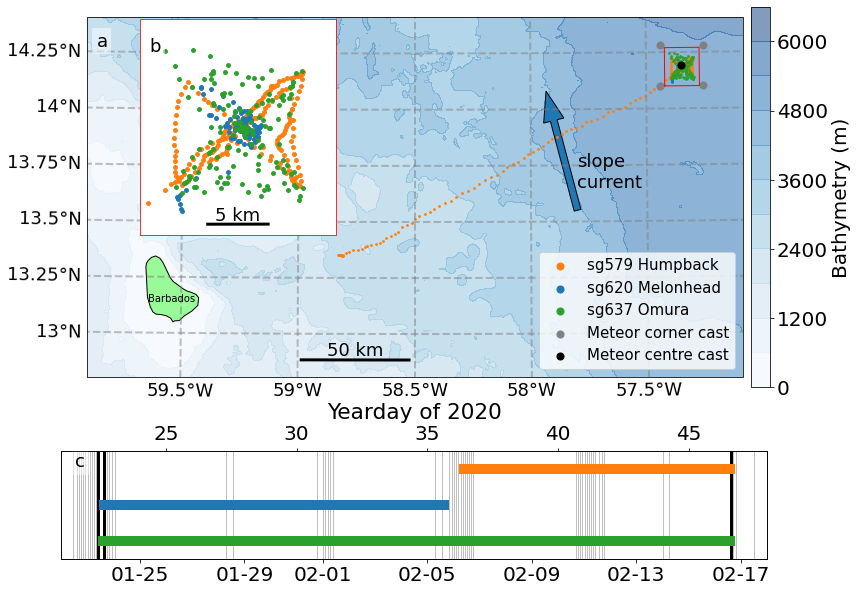

In [17]:
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-58.5, central_latitude=13.5))
coord=ccrs.PlateCarree()
ax.add_feature(land_10m)
ax.set_extent([-59.9, -57.1, 12.8, 14.4], crs=ccrs.PlateCarree());
mappable0 = ax.contourf(lon, lat, -bathy,10, transform=ccrs.PlateCarree(), cmap = 'Blues', alpha=0.5, zorder=-10)
gl = ax.gridlines(draw_labels=True, 
                 linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels=None
gl.right_labels=None
dot_size=3
dot_size_zoom=15
dot_size_p=50
ax.scatter(df_melon.lon, df_melon.lat,transform=ccrs.PlateCarree(), s=dot_size)
ax.scatter(df_hump.lon, df_hump.lat,transform=ccrs.PlateCarree(), s=dot_size)
ax.scatter(df_omura.lon, df_omura.lat,transform=ccrs.PlateCarree(), s=dot_size)

ax.scatter(df_hump.lon+100, df_hump.lat,transform=ccrs.PlateCarree(), s=dot_size_p, label='sg579 Humpback', c='C1')
ax.scatter(df_melon.lon+100, df_melon.lat,transform=ccrs.PlateCarree(), s=dot_size_p, label='sg620 Melonhead', c='C0')
ax.scatter(df_omura.lon+100, df_omura.lat,transform=ccrs.PlateCarree(), s=dot_size_p, label='sg637 Omura', c='C2')
ax.scatter(meteor_grid[:, 0], meteor_grid[:,1], transform = ccrs.PlateCarree(), color='gray',s=dot_size_p, label='Meteor corner cast')
ax.scatter(*center, transform = ccrs.PlateCarree(), color='k',s=dot_size_p, label='Meteor centre cast')
ax.plot([-57.42, -57.42, -57.27, -57.27, -57.42], [14.1, 14.27, 14.27, 14.1, 14.1], color='red', transform = ccrs.PlateCarree())
ax.legend(loc=4)

fig.colorbar(mappable=mappable0, ax=ax, label='Bathymetry (m)', shrink=0.7, pad=0.01)

sub_ax = plt.axes([0.15, 0.45, 0.25, 0.3], projection=ccrs.AlbersEqualArea(central_longitude=-57.5, central_latitude=14))
sub_ax.set_extent([-57.42, -57.27, 14.1, 14.27], crs=ccrs.PlateCarree())
sub_ax.scatter(df_hump.lon, df_hump.lat,transform=ccrs.PlateCarree(), s=dot_size_zoom, label='sg620 Humpback', c='C1')
sub_ax.scatter(df_melon.lon, df_melon.lat,transform=ccrs.PlateCarree(), s=dot_size_zoom, label='sg579 Melonhead', c='C0')
sub_ax.scatter(df_omura.lon, df_omura.lat,transform=ccrs.PlateCarree(), s=dot_size_zoom, label='sg637 Omura', c='C2')
for child in sub_ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('red')

scale_bar(ax, location=(0.41,0.05))
scale_bar(sub_ax, location=(0.5,0.05), length=5)
ax.text(-59.64, 13.14, 'Barbados', transform = ccrs.PlateCarree(), fontsize=10)

ax0 = plt.axes([0.1, 0, 0.7, 0.15])
for i, glider_span in enumerate([sg579_present, sg620_present, sg637_present]):
    ax0.plot(glider_span, [-i,-i], linewidth=10, label=platform_labels[i], zorder=10, color=platform_colors[i])
ax0.plot([0,0],[i+1, i+1], label='Meteor box cast', color='gray', linewidth=0.5)
for cast in ctd_outer_box_locs.datetime_first_scan:
    ax0.axvline(cast, color='gray', linewidth=0.5)
ax0.plot([0,0],[i+1, i+1], label='Meteor center cast', color='k', linewidth=3)
for cast in ctd_center_locs.datetime_first_scan:
    ax0.axvline(cast, color='k', linewidth=3)
ax0.set(xlim=[datetime(2020,1,22), datetime(2020,2,18)], ylim=[-2.5, 0.5])
myFmt = mdates.DateFormatter('%m-%d')
ax0.xaxis.set_major_formatter(myFmt)
ax1 = ax0.twiny()
ax1.plot(range(100), np.ones(100)*100) 

ax1.set_xlim([datetime(2020,1,22).timetuple().tm_yday-1, datetime(2020,2,18).timetuple().tm_yday-1])
ax0.set_title('Yearday of 2020')
ax0.set_yticks([]);
letterboxes([ax, sub_ax, ax0], loc=[[0.015, 0.92], [0.05, 0.85], [0.02, 0.85]])
ax.arrow(-57.8, 13.55, -0.1, 0.4, transform = ccrs.PlateCarree(), width=0.03, zorder=-1)
ax.text(-57.8, 13.65, 'slope\ncurrent', transform = ccrs.PlateCarree())
savefig('basemap')

# Tempsal scatter

In [18]:
omura_scat = glider_df.loc[(glider_df.glider=='sg637')]

In [19]:
omura_mix = mixes[mixes.dive>2000].copy()
bad_dives = (22, 22,5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    omura_mix[omura_mix.dive-2000==dive] = np.nan
omura_mix[omura_mix.sa>37.4] = np.nan

In [20]:
temp_step, sal_step = 0.1, 0.01
temp_grid = np.arange(5, 30, temp_step)
sal_grid = np.arange(34.5, 38, sal_step)
count_grid = np.zeros((len(temp_grid), len(sal_grid)))
for i, t in enumerate(temp_grid):
    for j, s in enumerate(sal_grid):
        df = omura_scat.loc[((np.abs(omura_scat.cons_temp - t))<temp_step/2) &
                            ((np.abs(omura_scat.abs_salinity - s))<sal_step/2)]
        count_grid[i, j] = len(df)
count_grid[count_grid==0] = np.nan   

ml_count_grid = np.zeros((len(temp_grid), len(sal_grid)))
for i, t in enumerate(temp_grid):
    for j, s in enumerate(sal_grid):
        df = omura_mix.loc[((np.abs(omura_mix.ct - t))<temp_step/2) &
                            ((np.abs(omura_mix.sa - s))<sal_step/2)]
        ml_count_grid[i, j] = len(df)
ml_count_grid[ml_count_grid<2] = np.nan  

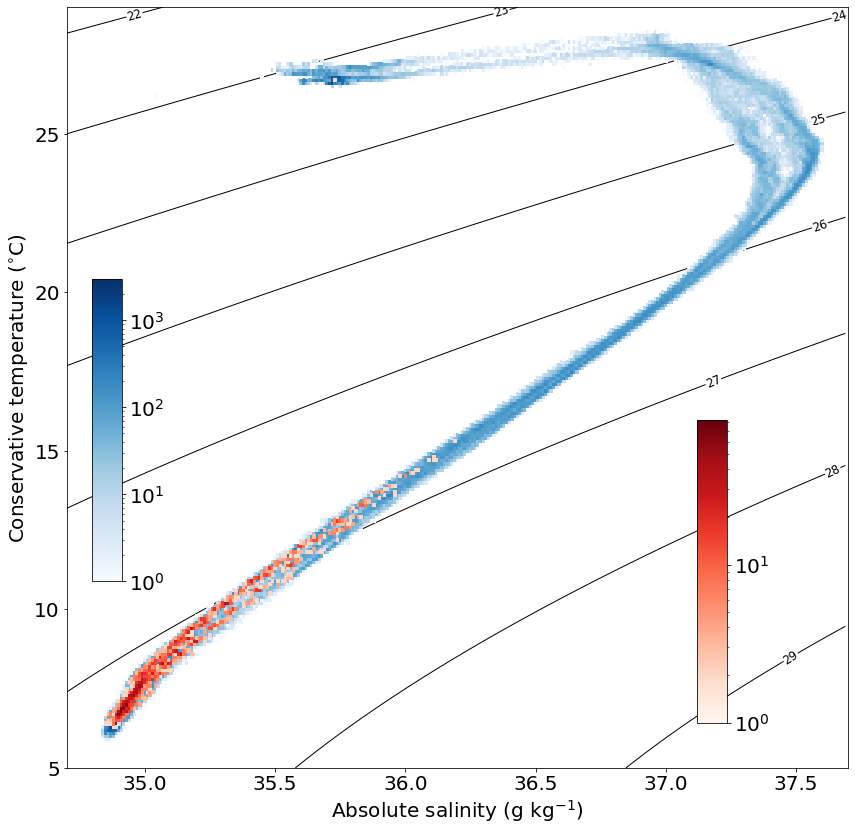

In [21]:
fig,ax = plt.subplots(1,1,figsize=(14,14))
den = ax.pcolor(sal_grid, temp_grid, count_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(count_grid)), shading='auto', cmap='Blues', zorder=-1)
#ax.scatter(omura_scat.abs_salinity, omura_scat.cons_temp, c=omura_scat.time_yday_local, alpha=0.3)
#ax.scatter(glider_350.abs_salinity, glider_350.cons_temp, c=glider_350.time_yday_local, alpha=0.3)
#mappable1 = ax.scatter(omura_mix.sa, omura_mix.ct, c=omura_mix.turner_ang,vmin=-180, vmax=180, s=1, cmap=turner_cmap)
ml_den = ax.pcolor(sal_grid, temp_grid, ml_count_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(ml_count_grid)), shading='auto', cmap='Reds', zorder=-1)

sal_lim = [34.7, 37.7]
temp_lim = [5, 29]
sal_ex,temp_ex = np.meshgrid(np.arange(sal_lim[0], sal_lim[1],0.01), np.arange(temp_lim[0],temp_lim[1],0.01))
seawater_density = gsw.rho(sal_ex, temp_ex, 0)
den_conts = np.arange(0,30,1)
mappable0=ax.contour(sal_ex[0,:],temp_ex[:,0],seawater_density-1000,den_conts,colors='k', zorder=-10)
#ax.clabel(mappable0)
ax.clabel(mappable0, inline=1,inline_spacing=0,fmt='%i', fontsize=12)
ax.set(xlim=sal_lim, ylim=temp_lim, xlabel=labels['sal'], ylabel=labels['temp'])
sub_ax =  plt.axes([0.15, 0.31, 0.03, 0.3])
fig.colorbar(mappable=den, cax=sub_ax)
sub_ax0 =  plt.axes([0.75, 0.17, 0.03, 0.3])
fig.colorbar(mappable=ml_den, cax=sub_ax0)
savefig('tempsal_scatter')

# Staircase

In [22]:
glider_df['dive_limb_dec'] = glider_df.dive_limb_ident - glider_df.dive + glider_df.dive_num

In [23]:
df_glider_1m['ml_mask_10m_plus'] = True
for i, mix in mixes.iterrows():
    if (mix.layer_height>=10) and (mix.bad_mixed_layer==False):
        df_glider_1m.loc[(df_glider_1m.p >= mix.p_start) & (df_glider_1m.p <= mix.p_end) &(df_glider_1m.dive == mix.dive), 'ml_mask_10m_plus'] = False

In [24]:
mixes_sum = mixes.groupby('dive').sum()
mixes_mean = mixes.groupby('dive').mean()
grads_sum = grads.groupby('dive').sum()
grads_mean = grads.groupby('dive').mean()

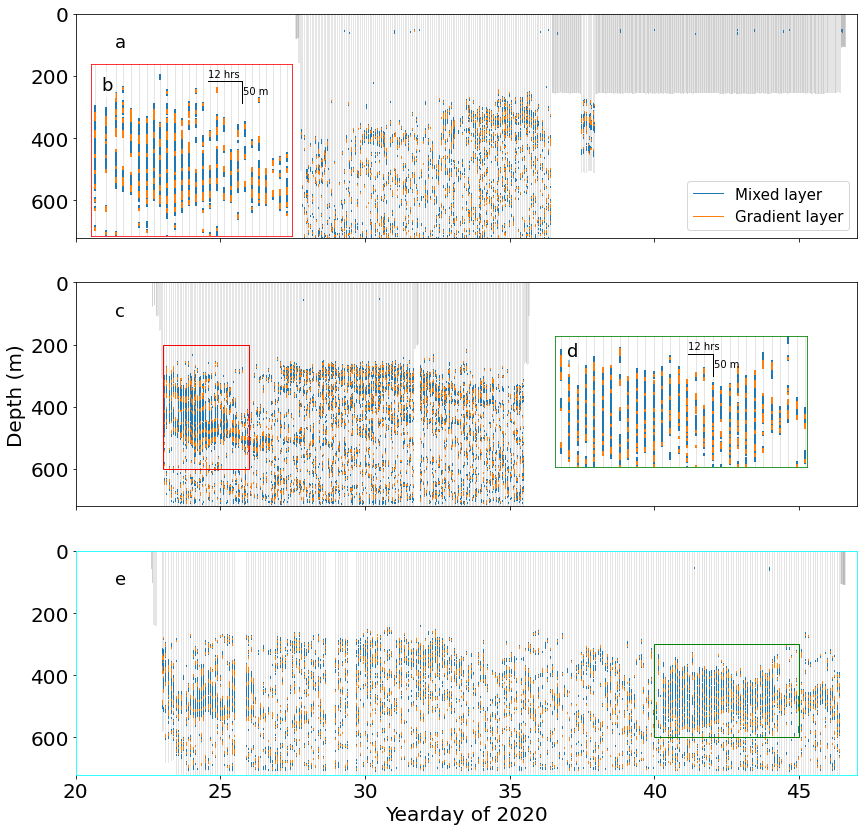

In [25]:
figa, axa = plt.subplots(3,1, figsize=(14,14), sharex='col', sharey=True)
for i, dive in enumerate(glider_df.dive_limb_dec.unique()):
    if dive>2000:
        ax = axa[2]
    elif dive<1000:
        ax = axa[0]
    else:
        ax = axa[1]
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax.plot(y, df.p, color='gray', alpha=0.2)
    ax.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0')
    ax.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1')

axa[0].plot((-1,-1), (-1,-1), color='C0', label='Mixed layer')
axa[0].plot((-1,-1), (-1,-1), color='C1', label='Gradient layer')
axa[0].legend(loc=4)
axa[1].set(ylabel='Depth (m)')
axa[2].set(xlabel='Yearday of 2020', xlim=(20, 47), ylim=(0, 720))
axa[0].invert_yaxis()

ax0 = plt.axes([0.14, 0.66, 0.2, 0.17])

ax1 = plt.axes([0.6, 0.43, 0.25, 0.13])


for i, dive in enumerate(np.arange(1000, 1050)):
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax0.plot(y, df.p, color='gray', alpha=0.2)
    ax0.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax0.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)
ax0.set(xlim=(23, 26), ylim=(200, 600), xticks=[], yticks=[])
ax0.invert_yaxis()

for i, dive in enumerate(np.arange(2080, 2150)):
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax1.plot(y, df.p, color='gray', alpha=0.2)
    ax1.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax1.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)
ax1.set(xlim=(40, 45), ylim=(300, 600), xticks=[], yticks=[])
ax1.invert_yaxis()


pt=axa[1].add_patch(patches.Rectangle((23,200),3,400,fill=False,zorder=20))
pt.set_ec('red')
pt=axa[2].add_patch(patches.Rectangle((40,300),5,300,fill=False,zorder=20))
pt.set_ec('green')

for child in ax0.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('red')
for child in ax1.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('green')  
for child in axa[2].get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('cyan')          
x, y = 24.75, 240
ax0.plot((x, x+0.5, x+0.5), (y, y, y+50), c='k')
ax0.text(x, y-10, '12 hrs', fontsize=10)
ax0.text(x+0.52, y+30, '50 m', fontsize=10)
x, y = 42.65, 340
ax1.plot((x, x+0.5, x+0.5), (y, y, y+50), c='k')
ax1.text(x, y-10, '12 hrs', fontsize=10)
ax1.text(x+0.52, y+30, '50 m', fontsize=10)   

letterboxes([axa[0], ax0, axa[1], ax1, axa[2]])
savefig('all_gliders_steps')

In [26]:
glider_df_mean = glider_df.groupby('dive_limb_dec').mean()
combi_a = glider_df_mean.join(mixes_sum, lsuffix='_glider', rsuffix='_mixes_sum')
combi_b = combi_a.join(mixes_mean, lsuffix='_mixes_sum', rsuffix='_mixes_mean')
combi_c = combi_b.join(grads_sum, lsuffix='_mixes_mean', rsuffix='_grads_sum')
combi_df = combi_c.join(grads_mean, lsuffix='_grads_sum', rsuffix='_grads_mean')
sg637_df = combi_df.loc[combi_df.index>2000]
sg620_df = combi_df.loc[(combi_df.index<2000) & (combi_df.index>1000)]

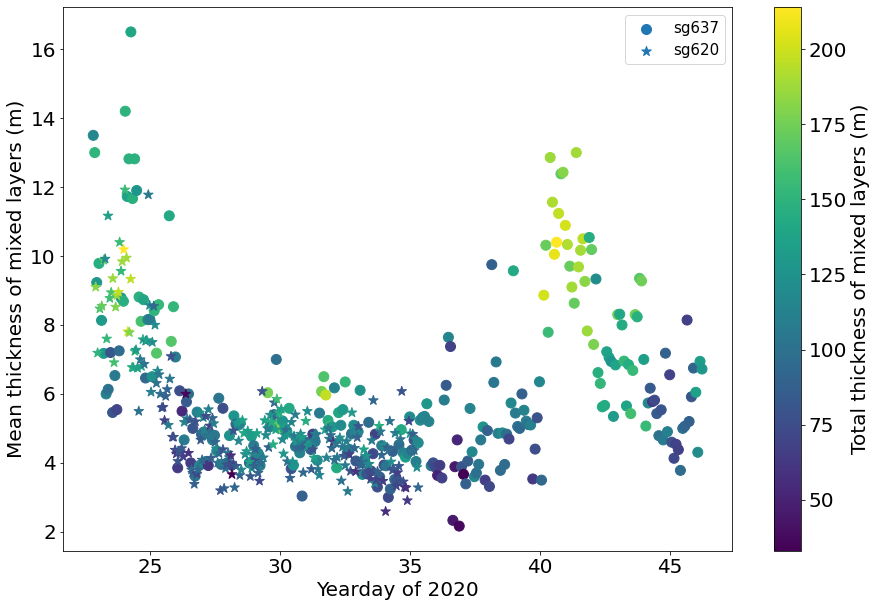

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
mp0 = ax.scatter(sg637_df.time_yday_local, sg637_df.layer_height_mixes_mean, c = sg637_df.layer_height_mixes_sum, cmap='viridis', label='sg637')
mp0 = ax.scatter(sg620_df.time_yday_local, sg620_df.layer_height_mixes_mean, c = sg620_df.layer_height_mixes_sum, cmap='viridis', marker='*', label='sg620')

fig.colorbar(mp0, ax=ax, label = 'Total thickness of mixed layers (m)')
ax.set(xlabel='Yearday of 2020', ylabel='Mean thickness of mixed layers (m)')
ax.legend()
savefig('mld_mean_depth')

In [28]:
dff = df_glider_1m.copy()
df_glider_multiindex = dff.set_index(['p', 'dive'])
ds_glider = xr.Dataset.from_dataframe(df_glider_multiindex)
ds_glider['ones'] = (('p','dive'), np.ones(np.shape(ds_glider.ct)))
ds_glider['ct_var'] = ds_glider.ct - ds_glider.ct.mean(dim='dive')

window = 50
ds_glider['ct_smooth'] = ds_glider.ct.copy()
for i in range(np.size(ds_glider['ct_smooth'],1)):
    ds_glider['ct_smooth'][:,i] = ds_glider.ct[:,i].to_dataframe().rolling(window, center=True).mean().ct.values

ds_glider['ct_dz'] = ds_glider['ct_smooth'].copy()
ds_glider['ct_dz'][0,:] = 0
ds_glider['ct_dz'][1:, :] = ds_glider['ct_smooth'][1:, :].values - ds_glider['ct_smooth'][:-1, :].values

ds_glider['sa_smooth'] = ds_glider.sa.copy()
for i in range(np.size(ds_glider['sa_smooth'],1)):
    ds_glider['sa_smooth'][:,i] = ds_glider.sa[:,i].to_dataframe().rolling(window, center=True).mean().sa.values
ds_glider['sa_dz'] = ds_glider['sa_smooth'].copy()
ds_glider['sa_dz'][0,:] = 0
ds_glider['sa_dz'][1:, :] = ds_glider['sa_smooth'][1:, :].values - ds_glider['sa_smooth'][:-1, :].values


mask = ds_glider.ml_mask_10m_plus.values.copy()
mask[:] = False
mask_angle = mask.copy()
mask_angle[(ds_glider.turner_ang>45) & (ds_glider.turner_ang<90)] = True
ds_glider['turner_angle_mask'] = (('p','dive'), mask_angle)

mask_den_ratio = mask.copy()
mask_den_ratio[(ds_glider.density_ratio>1) & (ds_glider.density_ratio<2.5)] = True
ds_glider['density_ratio_mask'] = (('p','dive'), mask_den_ratio)

mask_gradients = mask.copy()
mask_gradients[(np.abs(ds_glider.sa_dz)<0.006) & (np.abs(ds_glider.ct_dz)<0.05)] = True
ds_glider['gradients_mask'] = (('p','dive'), mask_gradients)

combined_mask = mask.copy()
combined_mask[(mask_gradients==True) & (mask_den_ratio==True) & (mask_angle==True)] = True
ds_glider['combined_mask'] = (('p','dive'), combined_mask)



ds_sg579 = ds_glider.loc[dict(dive=slice(0, 1000))]
ds_sg620 = ds_glider.loc[dict(dive=slice(1000, 2000))]
ds_sg637 = ds_glider.loc[dict(dive=slice(2000, 3000))]
ds_sg637['dive'] = ds_sg637.dive - 2000

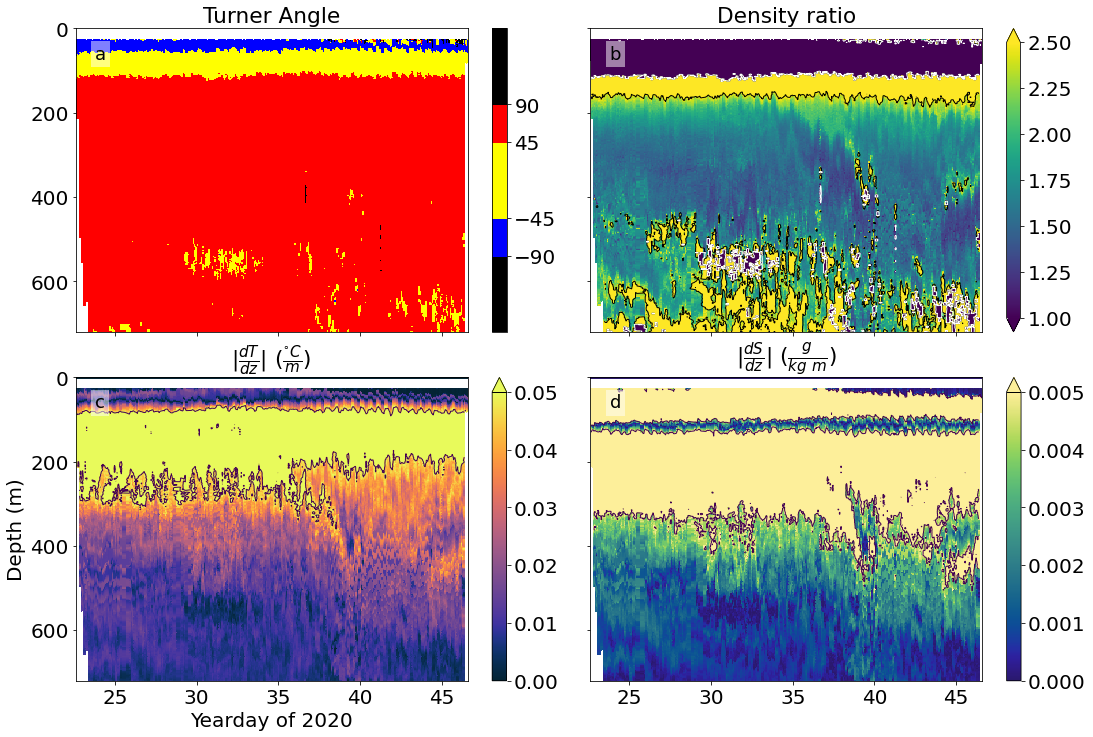

In [29]:
fig, ax = plt.subplots(2,2, figsize=(18,12), sharex=True, sharey=True, )
ax = ax.ravel()
plt.subplots_adjust(wspace=0.05, hspace=0.15)

p = ax[0].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.turner_ang, cmap=turner_cmap,vmin=-180, vmax=180, shading='auto')
fig.colorbar(mappable=p, ax = ax[0], ticks=[-90, -45, 45, 90])
ax[0].set_title('Turner Angle')

p = ax[1].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.density_ratio, cmap='viridis',vmin=1, vmax=2.5, shading='auto')
ax[1].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.density_ratio, [2.5], colors='k')
ax[1].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.density_ratio, [1], colors='white')
ax[1].set_title('Density ratio')
cb1 = fig.colorbar(mappable=p, ax = ax[1], extend='both')
cb1.ax.plot((0,1), (3, 3), color='k')
cb1.ax.plot((0,1), (1, 1), color='white')

p = ax[2].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.ct_dz), cmap=cmo.thermal, vmin=0, vmax=0.05, shading='auto')
ax[2].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.ct_dz),[0.05])
ax[2].set_title('|${\\frac{dT}{dz}}$| $(\\frac{^{\circ}C}{m})$')
cb2 = fig.colorbar(mappable=p, ax = ax[2], extend='max')
cb2.ax.plot((0,1), (0.05, 0.05), color='k')

p = ax[3].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.sa_dz), cmap=cmo.haline, vmin=0, vmax=0.005, shading='auto')
ax[3].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.sa_dz),[0.005])
ax[3].set_title('|${\\frac{dS}{dz}}$| $(\\frac{g}{kg\ m})$')
cb3 = fig.colorbar(mappable=p, ax = ax[3], extend='max')
cb3.ax.plot((0,1), (0.005, 0.005), color='k')
ax[2].set(ylabel='Depth (m)', xlabel='Yearday of 2020')
ax[2].set(ylim=(0, 720))
ax[2].invert_yaxis()
letterboxes(ax, loc=(0.05, 0.9))
savefig('sg637_key_variables_multipanel')

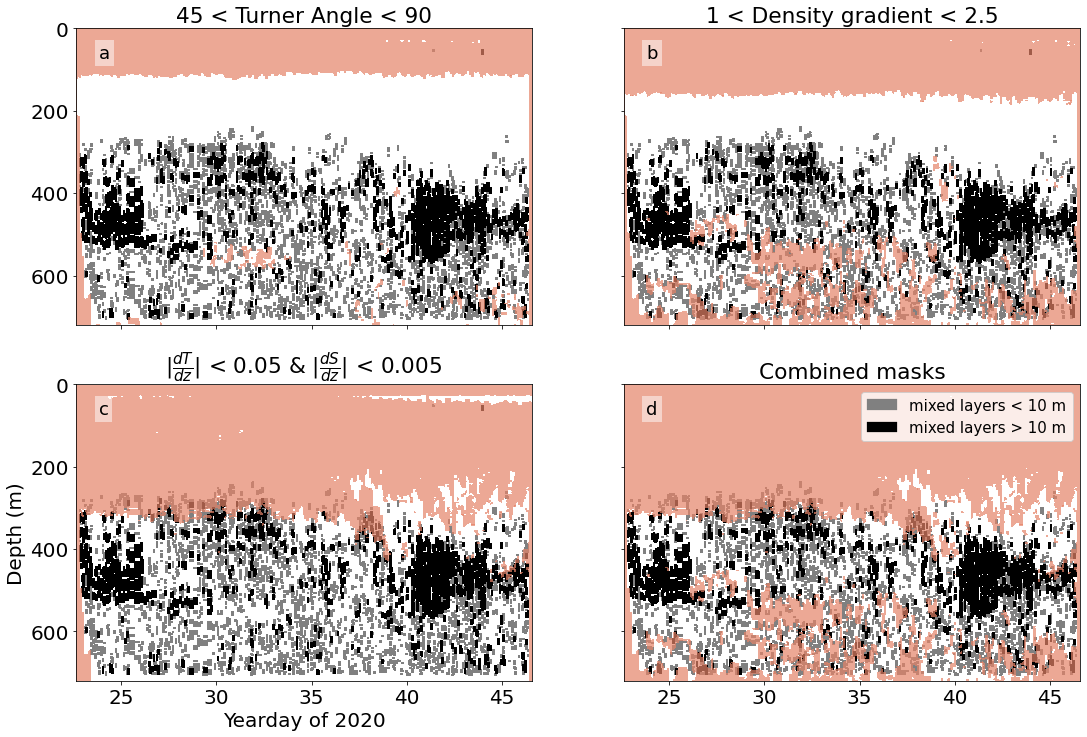

In [30]:
fig, ax = plt.subplots(2,2, figsize=(18,12), sharex=True, sharey=True)
ax = ax.ravel()
ax[0].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.turner_angle_mask)
              , cmap='RdBu', alpha=0.7)
ax[0].set_title('45 < Turner Angle < 90')
ax[1].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.density_ratio_mask)
              , cmap='RdBu', alpha=0.7)
ax[1].set_title('1 < Density gradient < 2.5')
ax[2].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.gradients_mask)
              , cmap='RdBu', alpha=0.7)
ax[2].set_title('|${\\frac{dT}{dz}}$| < 0.05 & |${\\frac{dS}{dz}}$| < 0.005')
ax[3].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.combined_mask)
              , cmap='RdBu', alpha=0.7)
ax[3].set_title('Combined masks')
for axa in ax:
    axa.pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.mixed_layer_salt_finger_mask), color='gray', label='mixed layers < 10 m', zorder=-10, shading='auto')
    axa.pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.ml_mask_10m_plus), color='k', label='mixed layers > 10 m', zorder=-5, shading='auto')
ax[3].legend()
ax[2].set(ylabel='Depth (m)', xlabel='Yearday of 2020')
ax[2].set(ylim=(0, 720))
ax[2].invert_yaxis()
letterboxes(ax, loc=(0.05, 0.9))
savefig('sg637_bitmask_multipanel')

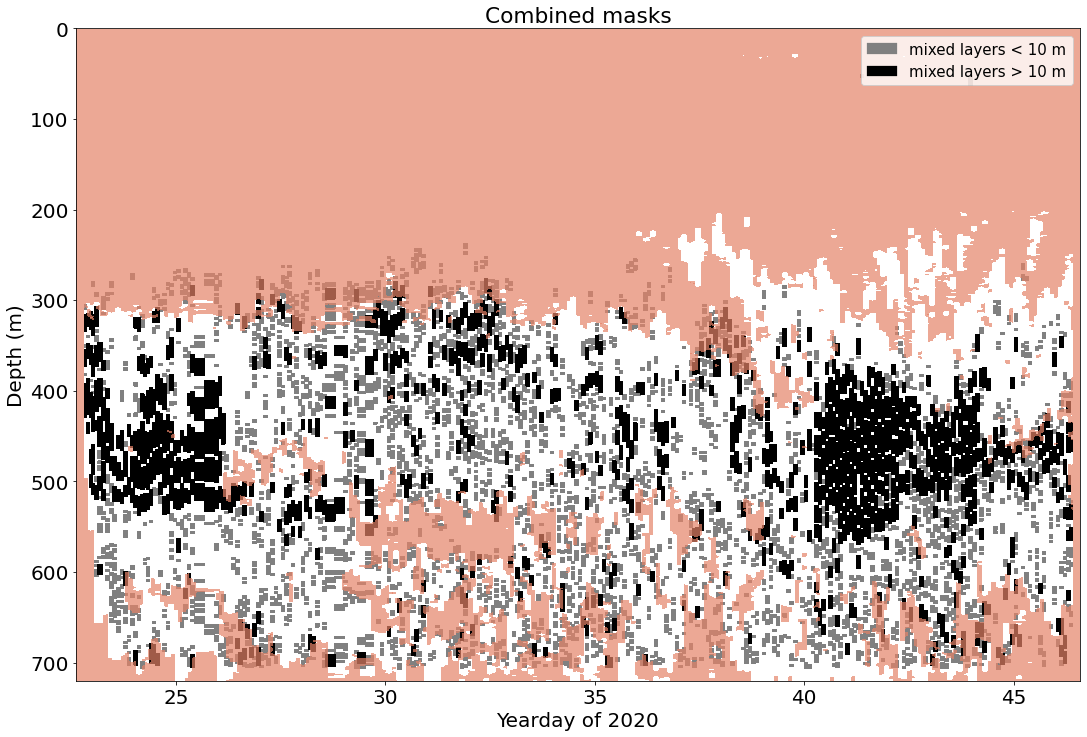

In [31]:
fig, ax = plt.subplots(figsize=(18,12))
ax.contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.combined_mask)
              , cmap='RdBu', alpha=0.7)
ax.set_title('Combined masks')

ax.pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.mixed_layer_salt_finger_mask), color='gray', label='mixed layers < 10 m', zorder=-10, shading='auto')
ax.pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.ml_mask_10m_plus), color='k', label='mixed layers > 10 m', zorder=-5, shading='auto')
ax.legend()
ax.set(ylabel='Depth (m)', xlabel='Yearday of 2020')
ax.set(ylim=(0, 720))
ax.invert_yaxis()
savefig('sg637_bitmask_final')

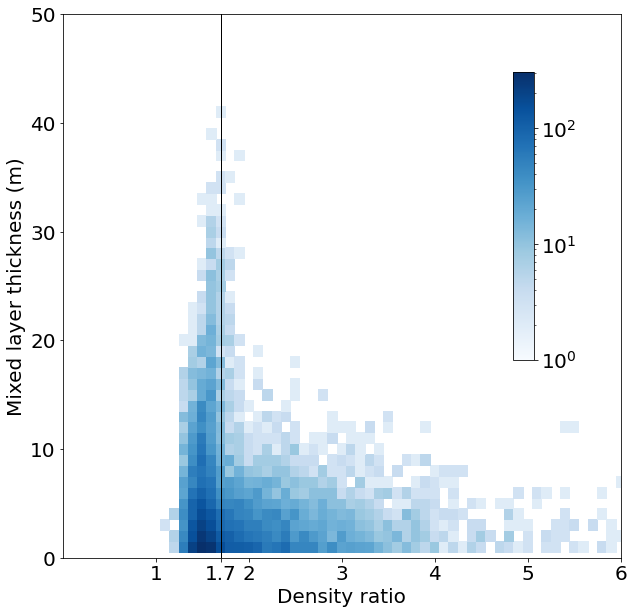

In [64]:
mixes_salt = mixes.loc[(mixes.salt_finger_step) & (mixes.p>100) & (mixes.p<800)]
ratio_step, mld_step = 0.1, 1
ratio_grid = np.arange(0, 10, ratio_step)
mld_grid = np.arange(1, 50, mld_step)
ml_ratio_grid = np.zeros((len(mld_grid), len(ratio_grid)))
for i, t in enumerate(mld_grid):
    for j, s in enumerate(ratio_grid):
        df = mixes_salt.loc[((np.abs(mixes_salt.layer_height - t))<mld_step/2) &
                            ((np.abs(mixes_salt.density_ratio - s))<ratio_step/2)]
        ml_ratio_grid[i, j] = len(df)
ml_ratio_grid[ml_ratio_grid<2] = np.nan  
fig, ax = plt.subplots(figsize=(10,10))
ml_den = ax.pcolor(ratio_grid, mld_grid, ml_ratio_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(ml_ratio_grid)), shading='auto', cmap='Blues', zorder=-1)
ax.set(xlim=(0,6), xlabel='Density ratio', ylabel='Mixed layer thickness (m)', ylim=(0, 50))
ax.axvline(1.7, color='k')
ax.set_xticks([1,1.7, 2,3,4, 5, 6])
ax.set_xticklabels([1,1.7, 2,3,4, 5, 6])
sub_ax0 =  plt.axes([0.75, 0.4, 0.03, 0.4])
fig.colorbar(mappable=ml_den, cax=sub_ax0)
savefig('density_ratio_layer_thinkness')

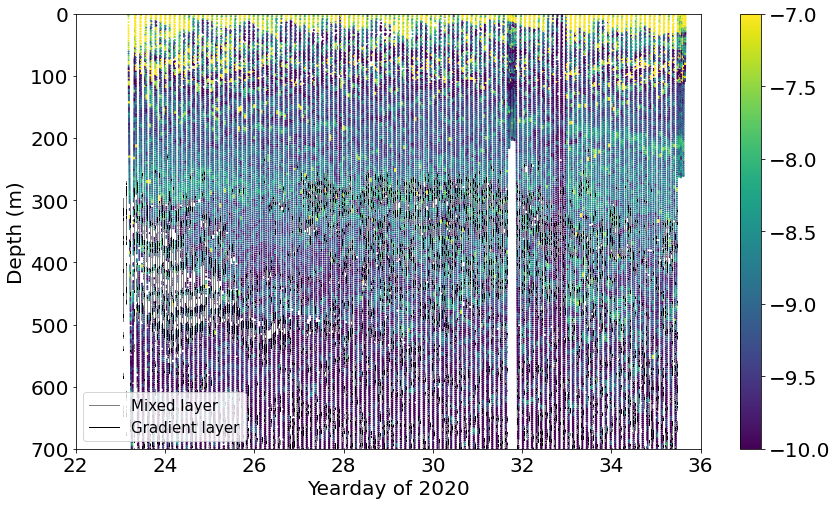

In [34]:
figa, ax = plt.subplots(figsize=(14,8), sharex='col', sharey=True)
mp = ax.scatter(df_dissapation.time_yday_utc, df_dissapation.P, c=df_dissapation.log_eps,  s=1,vmin=-10, vmax=-7, zorder=-10)
for i, dive in enumerate(glider_df.dive_limb_dec.unique()):
    if dive>2000:
        continue
    if dive<1000:
        continue
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='gray')
    ax.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='k')

ax.plot((-1,-1), (-1,-1), color='gray', label='Mixed layer')
ax.plot((-1,-1), (-1,-1), color='k', label='Gradient layer')
fig.colorbar(mappable=mp, ax = ax)
ax.legend(loc=3)
ax.set(ylabel='Depth (m)')
ax.set(xlabel='Yearday of 2020', xlim=(22, 36), ylim=(0, 700))
ax.invert_yaxis()
savefig('dissapation')

# Meteor compare

In [35]:
dive_df_smooth = df_glider_1m.loc[df_glider_1m.dive==1007, :]

In [36]:
micro_df_dive = df_micro_1m.loc[df_micro_1m.dive == 1007, :].copy()


In [37]:
met_dive_df = ctd_df[ctd_df.cast_no==29]
base = met_dive_df.pressure.max()
base_index = met_dive_df[met_dive_df.pressure==base].index[0]
met_cast_df = met_dive_df[met_dive_df.index<base_index].groupby('depth_bin').median()
dive_df = glider_df[(glider_df['glider']=='sg620') & (glider_df.dive==7)]

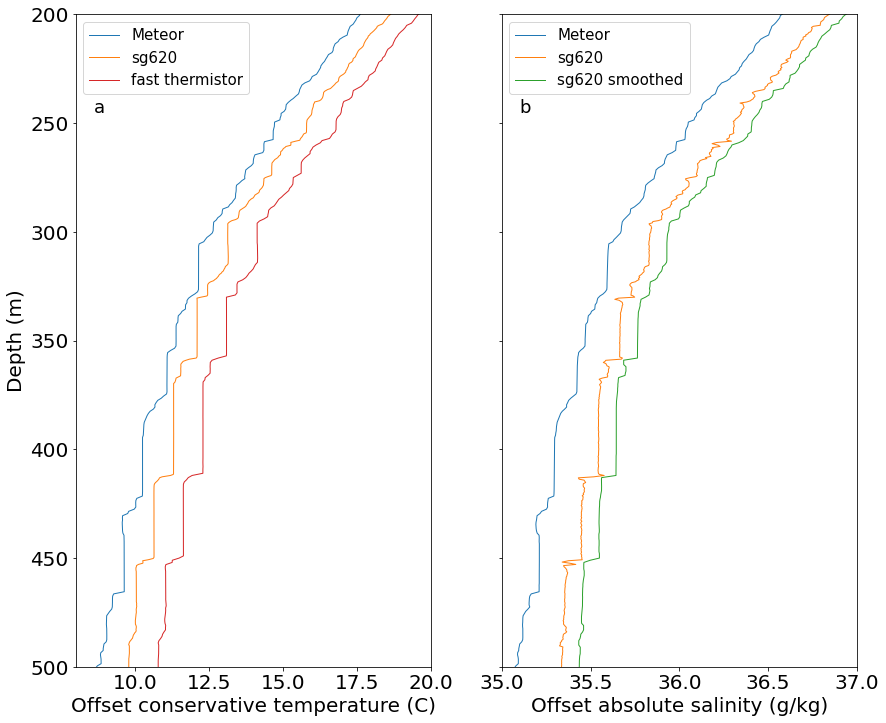

In [69]:
fig, ax = plt.subplots(1,2,figsize=(14,12), sharey='row')

ax[0].plot(met_cast_df.temp, met_cast_df.depth, label='Meteor')
ax[0].plot(dive_df.temp+1, dive_df.depth, label='sg620')
ax[1].plot(met_cast_df.absal, met_cast_df.depth, label='Meteor')
ax[1].plot(dive_df.abs_salinity+0.1, dive_df.depth, label='sg620')
#ax[1].plot(dive_df_smooth.abs_salinity+0.25, dive_df_smooth.depth, label='sg620 smoothed')
ax[1].plot(dive_df_smooth.sa+0.2, dive_df_smooth.p, label='sg620 smoothed')
ax[0].plot(micro_df_dive.ct+2, micro_df_dive.p, label='fast thermistor', color='C3')

#ax.plot(micro_df_dive.ct+2, micro_df_dive.p, label='Fast thermistor')
ax[0].legend()
ax[1].legend()
ax[0].set(ylabel='Depth (m)', xlabel='Offset conservative temperature (C)', xlim=(8, 20), ylim=(200, 500))
ax[1].set(xlabel='Offset absolute salinity (g/kg)', xlim=(35, 37))

ax[0].invert_yaxis()
letterboxes(ax)
savefig('obvs_compare')

# van der Boog compare

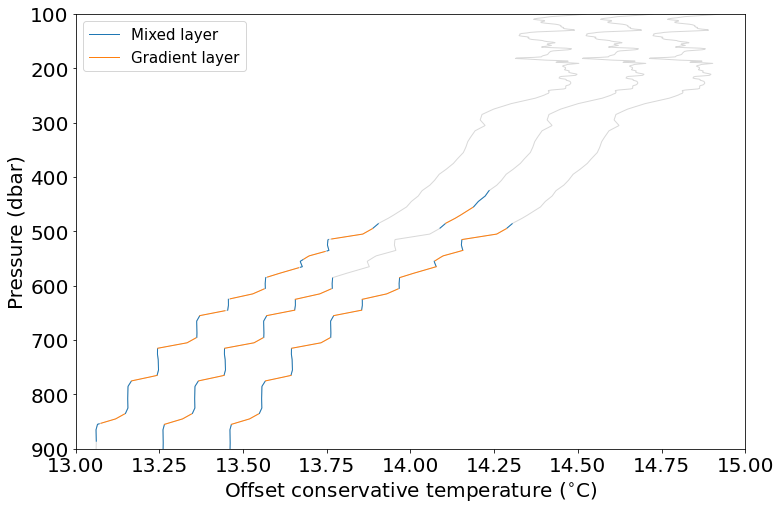

In [39]:
df_callum_argo, mixes_callum_argo, grads_callum_argo = classify_staircase(ds_vdb.pressure.values,
                                                                          ds_vdb.ct.values[0],
                                                                          ds_vdb.sa.values[0])

df_callum_argo_mod, mixes_callum_argo_mod, grads_callum_argo_mod = classify_staircase(ds_vdb.pressure.values,
                                                                          ds_vdb.ct.values[0],
                                                                          ds_vdb.sa.values[0],
                                                                          layer_height_ratio=0.9,
                                                                          ml_density_difference=0.0048)



fig, ax = plt.subplots(figsize=(12,8))
offset=0.2
ax.plot(ds_vdb.ct[0, :], ds_vdb.pressure, color='gray', alpha=0.3)
ax.plot(ds_vdb.ct[0,:] * ds_vdb.mask_ml_sf[0,:] / ds_vdb.mask_ml_sf[0,:], ds_vdb.pressure, color='C0', label='Mixed layer')
ax.plot(ds_vdb.ct[0,:] * ds_vdb.mask_gl_sf[0,:] / ds_vdb.mask_gl_sf[0,:], ds_vdb.pressure, color='C1', label='Gradient layer')
ax.plot(df_callum_argo.ct + offset, df_callum_argo.p, color='gray', alpha=0.3)
ax.plot(df_callum_argo.ct + offset*2, df_callum_argo.p, color='gray', alpha=0.3)
ax.plot(np.ma.array(df_callum_argo.ct, mask=df_callum_argo['mixed_layer_final_mask']) + offset, df_callum_argo.p, color='C0')
ax.plot(np.ma.array(df_callum_argo.ct, mask=df_callum_argo['gradient_layer_final_mask']) + offset, df_callum_argo.p, color='C1')
ax.plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['mixed_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C0')
ax.plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['gradient_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C1')
ax.set(xlim=(13, 15), ylim=(100, 900), xlabel='Offset conservative temperature ($^{\circ}$C)', ylabel='Pressure (dbar)')
ax.legend()
ax.invert_yaxis()
savefig('vdb_argo_comparison')

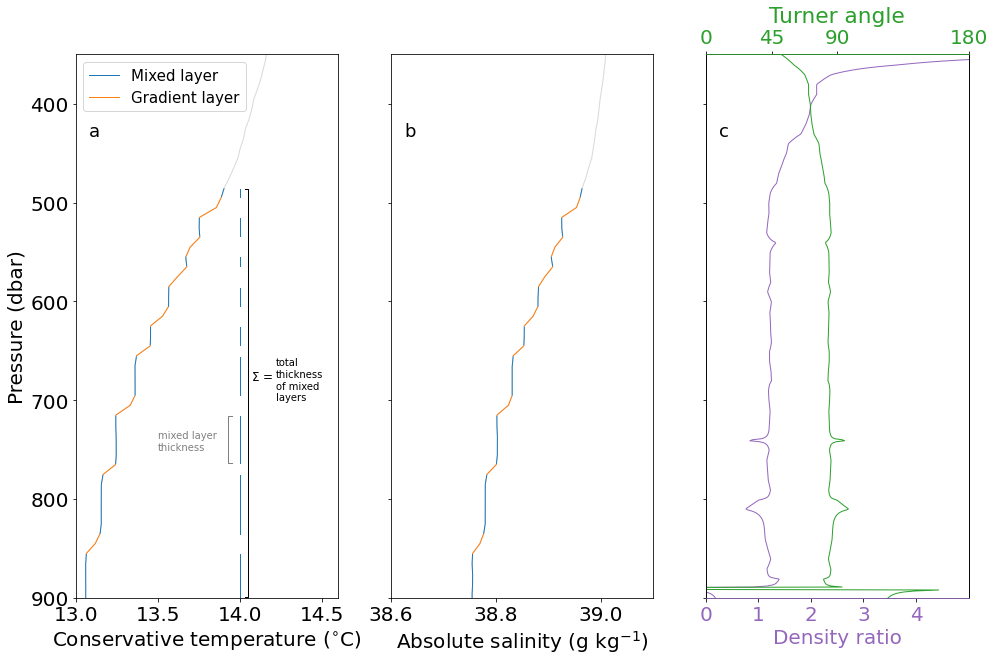

In [68]:
fig, ax = plt.subplots(1,3, sharey='row', figsize=(16,10))
ax = ax.ravel()
ax[0].plot(df_callum_argo.ct, df_callum_argo.p, color='gray', alpha=0.3)
ax[0].plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['mixed_layer_final_mask']) , df_callum_argo_mod.p, color='C0', label='Mixed layer')
ax[0].plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['gradient_layer_final_mask']), df_callum_argo_mod.p, color='C1', label='Gradient layer')
ax[1].plot(df_callum_argo.sa, df_callum_argo.p, color='gray', alpha=0.3)
ax[1].plot(np.ma.array(df_callum_argo_mod.sa, mask=df_callum_argo_mod['mixed_layer_final_mask']) , df_callum_argo_mod.p, color='C0', label='Mixed layer')
ax[1].plot(np.ma.array(df_callum_argo_mod.sa, mask=df_callum_argo_mod['gradient_layer_final_mask']), df_callum_argo_mod.p, color='C1', label='Gradient layer')

ax[2].plot(df_callum_argo_mod.density_ratio, df_callum_argo_mod.p, color='C4')
ax[2].set_title('Turner angle', c='C2')
ax[2].set(xlim=(0,5), xlabel='Density ratio', xticks=[0,1,2,3,4])
ax[2].set_xticklabels([0,1, 2,3,4], color='C4')
ax[2].xaxis.label.set_color('C4')

ax1 = ax[2].twiny()
ax1.plot(np.arange(0, 181), np.ones(181)*100) 
ax1.set(xlim=(0,180), xticks=[0, 45, 90, 180])

ax1.plot(df_callum_argo_mod.turner_ang, df_callum_argo_mod.p, c='C2')
ax1.spines['top'].set_color('C2') 
ax1.spines['bottom'].set_color('C4') 

ax1.set_xticklabels([0, 45, 90, 180], color='C2')
ax[0].set(xlim=(13, 14.6), ylim=(350, 900), xlabel=labels['temp'], ylabel='Pressure (dbar)')
ax[1].set(xlabel=labels['sal'], xlim=(38.6, 39.1))
ax[0].legend()
ax[0].invert_yaxis()

mix_x = 14
for i, mix in mixes_callum_argo_mod.iterrows():
    ax[0].plot([mix_x, mix_x], [mix.p_start, mix.p_end], color='C0')
ax[0].text(13.5, 750, "mixed layer\nthickness", fontsize=10, color='gray')
ax[0].text(14.07, 680, "$\\Sigma$ =", fontsize=12, color='k')
ax[0].text(14.22, 700, "total\nthickness\nof mixed\nlayers", fontsize=10, color='k')
ax[0].plot([14.03, 14.05, 14.05, 14.03], [899, 899, 486, 486], color='k')
ax[0].plot([13.95, 13.93, 13.93, 13.95], [716, 716, 764, 764], color='gray')
letterboxes(ax)

savefig('staircase_example')

# Shader

In [41]:
gsub = glider_df.loc[(glider_df.glider=='sg637') &(glider_df.direction==-1.0)]
gsub_mean = gsub.groupby('depth_bin').mean()
gsub_var = gsub[['cons_temp', 'depth', 'depth_bin', 'abs_salinity', 'sigma0']]
gsub_std = gsub_var.groupby('depth_bin').std()
gav_sub = glider_av_df.loc[(glider_av_df.dive_limb_ident>2000) &(glider_av_df.direction==-1.0)]
gav_sub['day'] = np.floor(gav_sub.time_yday_local)
gav_day = gav_sub.groupby('day').mean()

<ipython-input-41-d2027bac6477>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gav_sub['day'] = np.floor(gav_sub.time_yday_local)


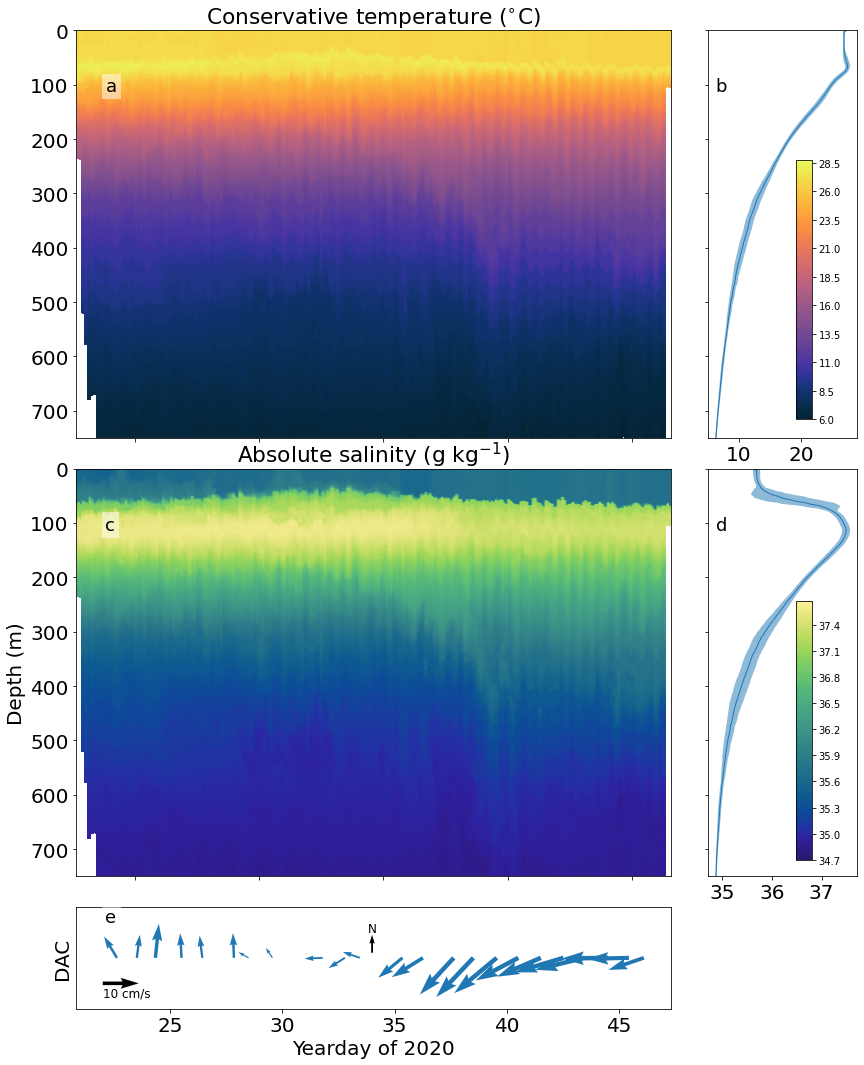

In [43]:
fig, ax = plt.subplots(3,2, figsize=(14,18),sharey="row",
    gridspec_kw={"height_ratios": [2,2,0.5], "width_ratios": [4, 1]})

fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()
kwargs = {'cmap':cmo.thermal}
mp0 = ax[0].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.ct,np.arange(6, 29, 0.25),**kwargs)
#ax[0].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, colors='k')
ax[1].plot(gsub_mean.cons_temp, gsub_mean.depth)
ax[1].fill_betweenx(gsub_mean.depth, gsub_mean.cons_temp-gsub_std.cons_temp, 
                  gsub_mean.cons_temp+gsub_std.cons_temp, alpha=0.5)
ax[0].set(xticklabels=[], title=labels['temp'], ylim=[0, 750])
sub_ax0 =  plt.axes([0.84, 0.58, 0.015, 0.2])
cbar0 = fig.colorbar(mappable=mp0, cax=sub_ax0)
cbar0.ax.tick_params(labelsize=10)

mp1 = ax[2].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.sa,np.arange(34.7, 37.7, 0.02), cmap=cmo.haline)
#ax[2].contour(x,-y,pden, colors='k')
ax[2].set(xticklabels=[], ylabel='Depth (m)', title=labels['sal'], ylim=[0, 750])

ax[3].plot(gsub_mean.abs_salinity, gsub_mean.depth)
ax[3].fill_betweenx(gsub_mean.depth, gsub_mean.abs_salinity-gsub_std.abs_salinity, 
                  gsub_mean.abs_salinity+gsub_std.abs_salinity, alpha=0.5)
sub_ax1 =  plt.axes([0.84, 0.24, 0.015, 0.2])
cbar1 = fig.colorbar(mappable=mp1, cax=sub_ax1)
cbar1.ax.tick_params(labelsize=10)


ax[4].quiver(gav_day.time_yday_local, np.zeros(len(gav_day.x)), gav_day.DAC_u, gav_day.DAC_v, scale=0.2, scale_units='inches', minlength=2, minshaft=2, color='C0')
ax[4].quiver([22, 34], [-0.1, 0.02], [0.1, 0],[0, 0.05], scale=0.2, scale_units='inches', minlength=2, minshaft=2)
ax[4].text(22, -0.15, "10 cm/s", fontsize=12)
ax[4].text(33.8,0.1, "N", fontsize=12)

ax[4].set(ylim=[-0.2, 0.2], xlabel='Yearday of 2020', yticks=[], ylabel='DAC')
ax[5].axis('off')
ax[0].invert_yaxis()
ax[2].invert_yaxis()
letterboxes(ax[:5])
savefig('shader')

# Experiment